In [ ]:
!pip install networkx_robustness
!pip install powerlaw

In [ ]:
import networkx as nx
import pandas as pd

G = nx.read_gml("graph.gml")
G = nx.read_graphml("graph.graphml")

G = nx.read_adjlist("graph.adjlist")
G = nx.read_edgelist("graph.edgelist", nodetype=int)
G = nx.read_multiline_adjlist("graph.multiadjlist")

df = pd.read_csv("edges.csv")
G = nx.from_pandas_edgelist(df, source="source", target="target")

## Generate BA Network

=== Barabási–Albert Network Analysis ===
Average Shortest Path Length: 3.466
Average Clustering Coefficient: 0.033
Diameter: 6
Degree Assortativity Coefficient: -0.076
Minimum Degree: 3
Maximum Degree: 93
Average Degree: 5.982
Power-law Exponent (log–log fit): 3.111
Power-law xmin (threshold used): 5.0
Top 5 Hubs by Betweenness: [4, 6, 5, 7, 12]
Largest Component after 20% Random Removal: 798
Largest Component after 20% Targeted Removal: 530


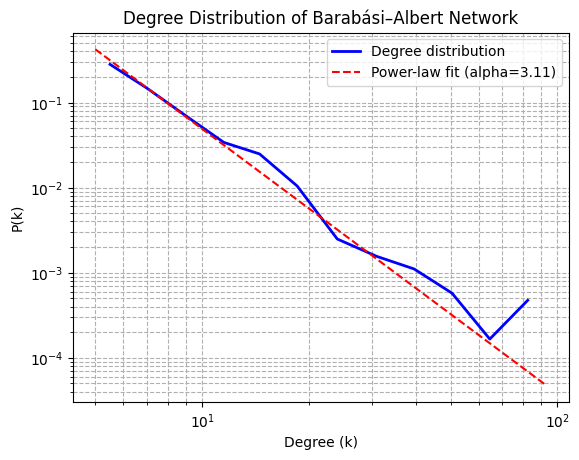

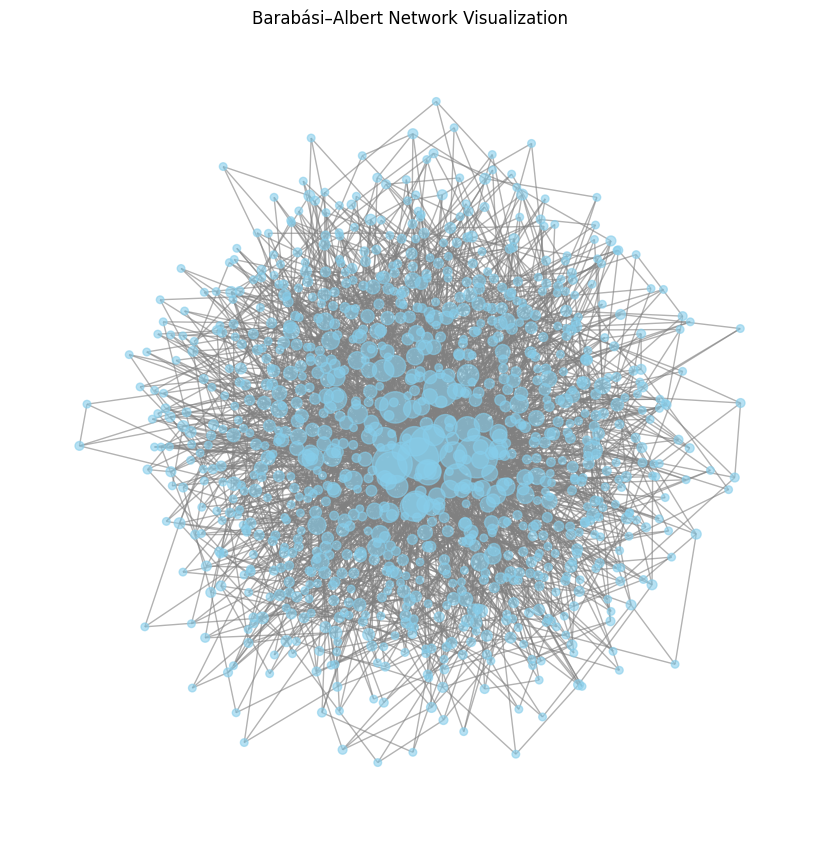

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from powerlaw import Fit

n = 1000
m = 3
G = nx.barabasi_albert_graph(n, m, seed=42)

avg_path_length = nx.average_shortest_path_length(G)
avg_clustering = nx.average_clustering(G)
diameter = nx.diameter(G)
assortativity = nx.degree_assortativity_coefficient(G)

degrees = [d for _, d in G.degree()]
min_degree = min(degrees)
max_degree = max(degrees)
avg_degree = np.mean(degrees)

fit = Fit(degrees, verbose=False)
power_law_alpha = fit.power_law.alpha
power_law_xmin = fit.power_law.xmin

betweenness = nx.betweenness_centrality(G)
top_hubs = sorted(betweenness, key=betweenness.get, reverse=True)[:5]

def percolation(G, fraction, targeted=False):
    G_copy = G.copy()
    num_remove = int(fraction * G_copy.number_of_nodes())
    if targeted:
        nodes_to_remove = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
        nodes_to_remove = [n for n, _ in nodes_to_remove[:num_remove]]
    else:
        nodes_to_remove = list(G_copy.nodes())
        np.random.shuffle(nodes_to_remove)
        nodes_to_remove = nodes_to_remove[:num_remove]
    G_copy.remove_nodes_from(nodes_to_remove)
    comps = list(nx.connected_components(G_copy))
    return len(max(comps, key=len, default=set()))

largest_component_random   = percolation(G, 0.2, targeted=False)
largest_component_targeted = percolation(G, 0.2, targeted=True)

print("=== Barabási–Albert Network Analysis ===")
print(f"Average Shortest Path Length: {avg_path_length:.3f}")
print(f"Average Clustering Coefficient: {avg_clustering:.3f}")
print(f"Diameter: {diameter}")
print(f"Degree Assortativity Coefficient: {assortativity:.3f}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")
print(f"Average Degree: {avg_degree:.3f}")
print(f"Power-law Exponent (log–log fit): {power_law_alpha:.3f}")
print(f"Power-law xmin (threshold used): {power_law_xmin}")
print(f"Top 5 Hubs by Betweenness: {top_hubs}")
print(f"Largest Component after 20% Random Removal: {largest_component_random}")
print(f"Largest Component after 20% Targeted Removal: {largest_component_targeted}")

fig = fit.plot_pdf(color='b', linewidth=2, label='Degree distribution')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label=f'Power-law fit (alpha={fit.alpha:.2f})')

plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Distribution of Barabási–Albert Network')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, seed=42)
node_sizes = [d*10 for _, d in G.degree()]
nx.draw(G, pos, node_size=node_sizes, node_color='skyblue',
        edge_color='gray', alpha=0.6)
plt.title('Barabási–Albert Network Visualization')
plt.show()



In [ ]:
import networkx as nx
G = nx.barabasi_albert_graph(n=1000, m=3)

## Given a Pseudocode:

Input:
    n  = total number of nodes to create
    m  = number of edges each new node will add
    seed_graph = small initial connected graph with at least m nodes
Output:
    G  = Barabási–Albert graph with n nodes

Algorithm:

1.  Initialize G with a small connected graph of size m0 ≥ m
    (for example, a complete graph of m0 nodes).

2.  While the number of nodes in G < n:
        a. Create a new node v.
        b. For each of the m edges to attach:
               i.  Select an existing node u from G
                   with probability proportional to its degree:
                         P(u) = degree(u) / sum of degrees of all nodes in G.
              ii.  If v is not already connected to u, add an edge (v, u).
        c. Add v and all new edges to G.

3.  Return the final graph G.


In [ ]:
import random
from collections import defaultdict

def ba_graph(n: int, m: int, seed: int = None):
    if seed is not None:
        random.seed(seed)

    if m < 1 or m >= n:
        raise ValueError("Require 1 <= m < n.")

    m0 = m
    graph = {i: set(j for j in range(m0) if j != i) for i in range(m0)}

    node_pool = []
    for i in range(m0):
        node_pool.extend([i]*m0)
    node_pool = []
    for i in range(m0):
        node_pool.extend([i]*(m0-1))

    for new_node in range(m0, n):
        graph[new_node] = set()
        targets = set()
        while len(targets) < m:
            chosen = random.choice(node_pool)
            if chosen not in targets:
                targets.add(chosen)
        for t in targets:
            graph[new_node].add(t)
            graph[t].add(new_node)
        node_pool.extend([new_node]*m)
        for t in targets:
            node_pool.append(t)

    return graph


G_dict = ba_graph(n=20, m=2, seed=42)
G_nx = nx.Graph(G_dict)


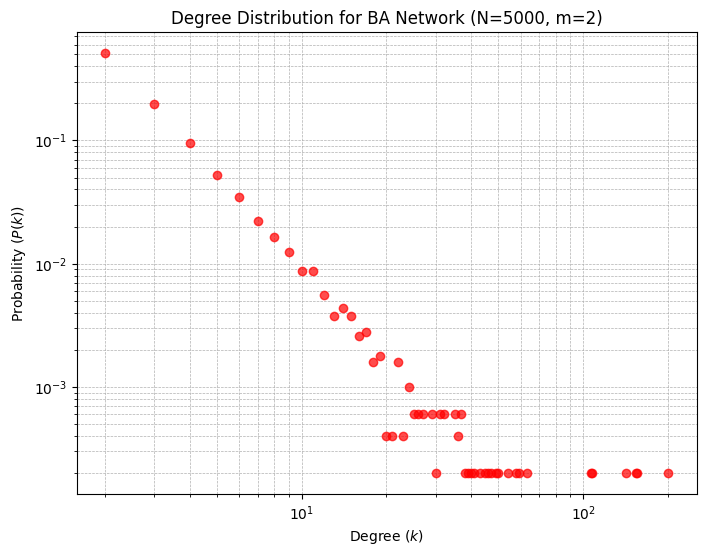

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def create_barabasi_albert_graph(n, m, seed_graph=None):
    G = nx.complete_graph(m)

    m0 = G.number_of_nodes()

    total_degree = 2 * G.number_of_edges()
    existing_nodes = list(G.nodes())

    for v_index in range(m0, n):
        v = v_index

        current_degrees = [d for _, d in G.degree]

        if total_degree == 0:
            probabilities = np.ones(len(existing_nodes)) / len(existing_nodes)
        else:
            probabilities = np.array(current_degrees) / total_degree

        targets = []
        while len(targets) < m:
            new_target = np.random.choice(existing_nodes, p=probabilities)
            if new_target not in targets:
                targets.append(new_target)

        G.add_node(v)

        new_edges = [(v, u) for u in targets]

        G.add_edges_from(new_edges)

        total_degree += 2 * m
        existing_nodes.append(v)

    return G

N_NODES = 5000
M_EDGES = 2

G_ba = create_barabasi_albert_graph(n=N_NODES, m=M_EDGES)

degree_sequence = [d for n, d in G_ba.degree()]
degree_counts = nx.degree_histogram(G_ba)

degrees = np.arange(len(degree_counts))
probabilities = np.array(degree_counts) / N_NODES

valid_indices = probabilities > 0
degrees = degrees[valid_indices]
probabilities = probabilities[valid_indices]

plt.figure(figsize=(8, 6))

plt.loglog(degrees, probabilities, 'o', color='red', alpha=0.7)
plt.title(f'Degree Distribution for BA Network (N={N_NODES}, m={M_EDGES})')
plt.xlabel('Degree ($k$)')
plt.ylabel('Probability ($P(k)$)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

## Robustness of BA network

BA Random Failure Threshold: 0.84
ER Theoretical Random Threshold: 0.83


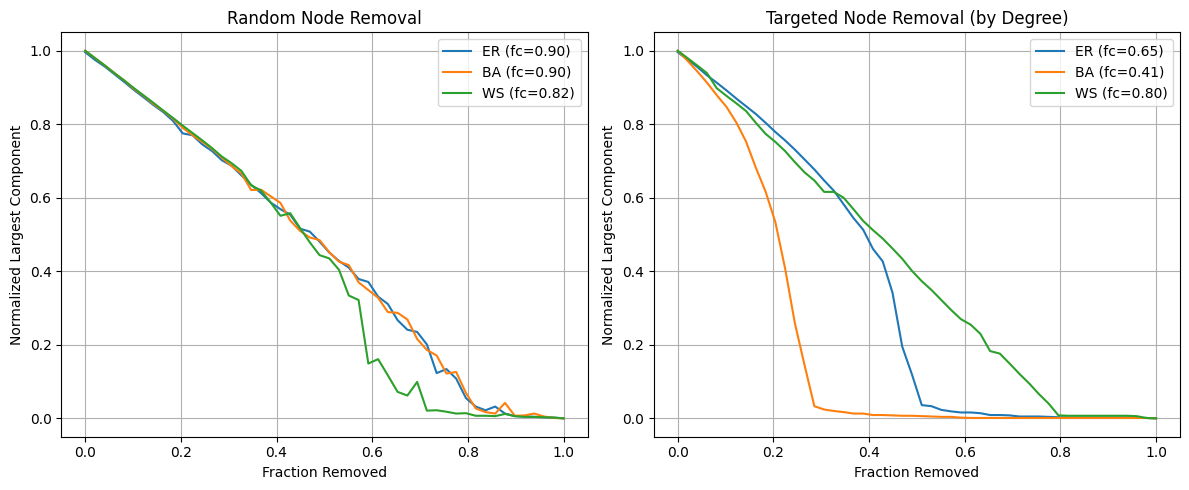

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def generate_networks(n=1000, p_er=0.006, m_ba=3, k_ws=6, p_ws=0.1):
    ER = nx.erdos_renyi_graph(n, p_er)
    BA = nx.barabasi_albert_graph(n, m_ba)
    WS = nx.watts_strogatz_graph(n, k_ws, p_ws)
    return ER, BA, WS

def percolation_simulation(G, removal_type='random', steps=50):
    N = len(G)
    fractions = np.linspace(0, 1, steps)
    largest_components = []
    for f in fractions:
        G_copy = G.copy()
        if removal_type == 'targeted':
            nodes_sorted = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node[0] for node in nodes_sorted[:int(f * N)]]
        else:
            nodes_to_remove = list(G_copy.nodes())
            np.random.shuffle(nodes_to_remove)
            nodes_to_remove = nodes_to_remove[:int(f * N)]
        G_copy.remove_nodes_from(nodes_to_remove)
        if len(G_copy) == 0:
            largest = 0
        else:
            components = nx.connected_components(G_copy)
            largest = max(len(c) for c in components) / N
        largest_components.append(largest)
    return fractions, largest_components

def find_failure_threshold(fractions, largest_components, threshold=0.01):
    for i, size in enumerate(largest_components):
        if size <= threshold:
            return fractions[i]
    return 1.0

def plot_percolation(ER, BA, WS):
    networks = {'ER': ER, 'BA': BA, 'WS': WS}
    strategies = {
        'Random Node Removal': 'random',
        'Targeted Node Removal (by Degree)': 'targeted'
    }

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for ax, (title, mode) in zip(axs, strategies.items()):
        for name, G in networks.items():
            fr, lc = percolation_simulation(G, mode)
            fc = find_failure_threshold(fr, lc)
            ax.plot(fr, lc, label=f'{name} (fc={fc:.2f})')
        ax.set_title(title)
        ax.set_xlabel('Fraction Removed')
        ax.set_ylabel('Normalized Largest Component')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


def er_theoretical_threshold(G):
    avg_degree = np.mean([d for n, d in G.degree()])
    return 1 - 1 / avg_degree if avg_degree > 1 else 0


ER, BA, WS = generate_networks()
fr, lc = percolation_simulation(BA, 'random')
fc = find_failure_threshold(fr, lc)
print(f"BA Random Failure Threshold: {fc:.2f}")
fc_theory = er_theoretical_threshold(ER)
print(f"ER Theoretical Random Threshold: {fc_theory:.2f}")
plot_percolation(ER, BA, WS)


In [ ]:
import networkx as nx
import numpy as np

def random_attack(G, percent=30):
    """Simulate random removal of a percentage of nodes."""
    num_nodes_to_remove = int(len(G) * percent / 100)
    removed_nodes = np.random.choice(G.nodes(), size=num_nodes_to_remove, replace=False)
    G_after = G.copy()
    G_after.remove_nodes_from(removed_nodes)

    # Fraction of nodes remaining in the largest connected component
    giant = max(nx.connected_components(G_after), key=len)
    giant_frac = len(giant) / len(G)

    return G_after, removed_nodes, giant_frac



=== ER ===
Before removal:
  Nodes               : 100
  Edges               : 224
  Average degree      : 4.48
  Density             : 0.0453
After 30% random removal:
  Nodes               : 70
  Edges               : 121
  Average degree      : 3.46
  Density             : 0.0501
Fraction of nodes in giant component after removal: 0.68

=== BA ===
Before removal:
  Nodes               : 100
  Edges               : 196
  Average degree      : 3.92
  Density             : 0.0396
After 30% random removal:
  Nodes               : 70
  Edges               : 87
  Average degree      : 2.49
  Density             : 0.036
Fraction of nodes in giant component after removal: 0.66

=== WS ===
Before removal:
  Nodes               : 100
  Edges               : 200
  Average degree      : 4.0
  Density             : 0.0404
After 30% random removal:
  Nodes               : 70
  Edges               : 93
  Average degree      : 2.66
  Density             : 0.0385
Fraction of nodes in giant componen

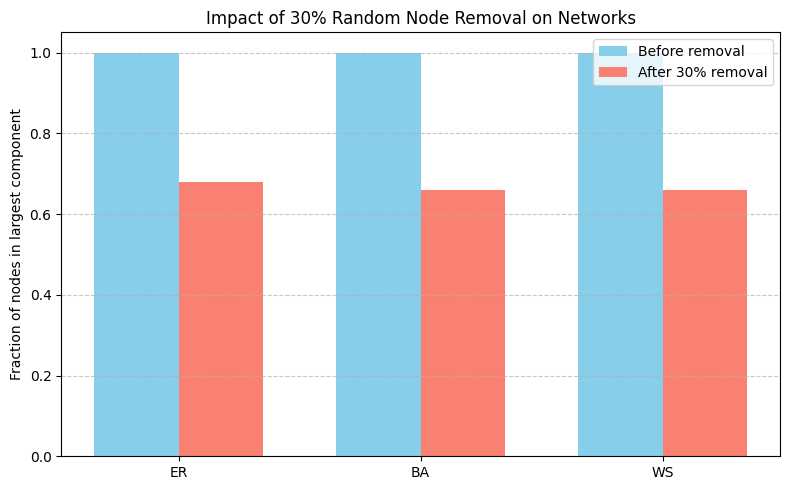

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random

def graph_properties(G):
    return {
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "Average degree": round(sum(dict(G.degree()).values())/len(G), 2),
        "Density": round(nx.density(G), 4)
    }

def random_attack(G, percent=30):
    G_copy = G.copy()
    n_remove = int(len(G_copy) * percent / 100)
    removed_nodes = random.sample(list(G_copy.nodes()), n_remove)
    G_copy.remove_nodes_from(removed_nodes)
    if len(G_copy) == 0:
        giant_frac = 0.0
    else:
        giant = max(nx.connected_components(G_copy), key=len)
        giant_frac = len(giant) / len(G)
    return G_copy, removed_nodes, giant_frac

graphs = {
    "ER": nx.erdos_renyi_graph(n=100, p=0.05, seed=42),
    "BA": nx.barabasi_albert_graph(n=100, m=2, seed=42),
    "WS": nx.watts_strogatz_graph(n=100, k=4, p=0.1, seed=42)
}

labels, frac_before, frac_after = [], [], []

for label, G in graphs.items():
    props_before = graph_properties(G)
    G_after, removed_nodes, giant_after = random_attack(G, percent=30)
    props_after = graph_properties(G_after)
    giant_before = 1.0 if nx.is_connected(G) else \
        len(max(nx.connected_components(G), key=len)) / len(G)
    labels.append(label)
    frac_before.append(giant_before)
    frac_after.append(giant_after)
    print(f"\n=== {label} ===")
    for phase, props in [
        ("Before removal", props_before),
        ("After 30% random removal", props_after)
    ]:
        print(phase + ":")
        for k, v in props.items():
            print(f"  {k:20s}: {v}")
    print(f"Fraction of nodes in giant component after removal: {giant_after:.2f}")

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, frac_before, width, label="Before removal", color="skyblue")
plt.bar([i + width for i in x], frac_after, width, label="After 30% removal", color="salmon")
plt.xticks([i + width/2 for i in x], labels)
plt.ylabel("Fraction of nodes in largest component")
plt.title("Impact of 30% Random Node Removal on Networks")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


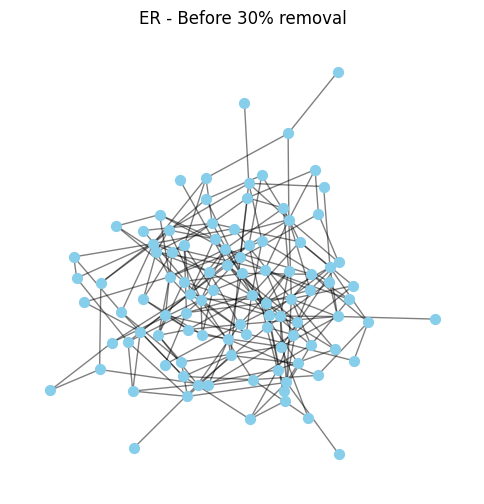

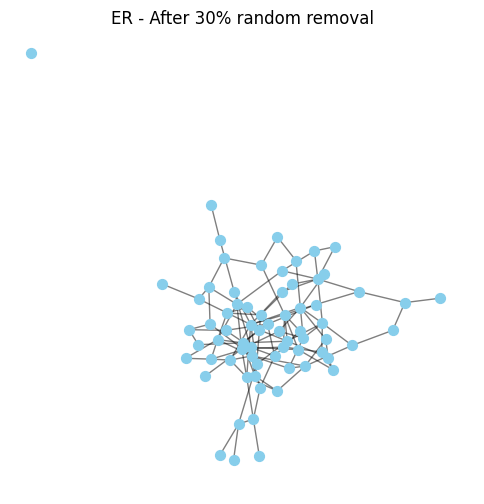

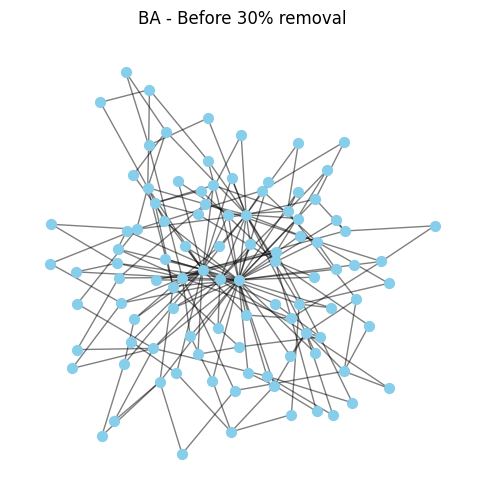

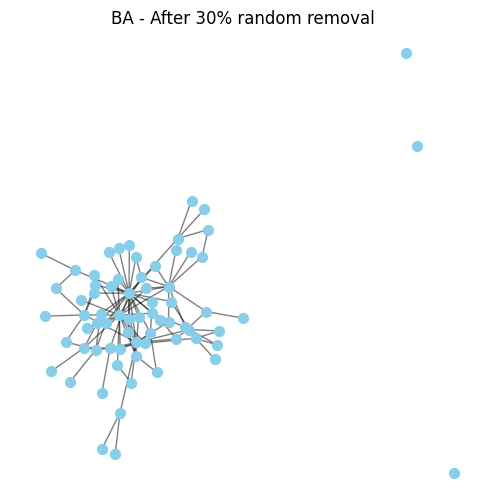

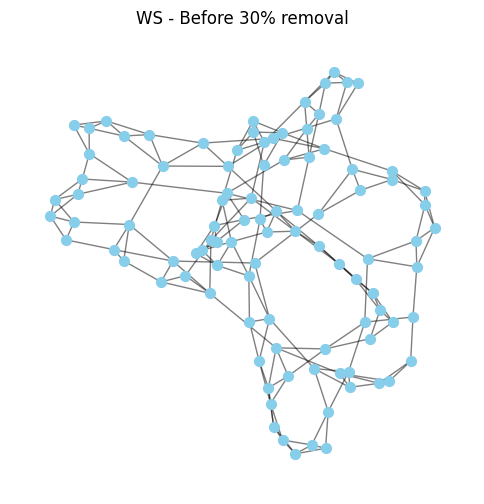

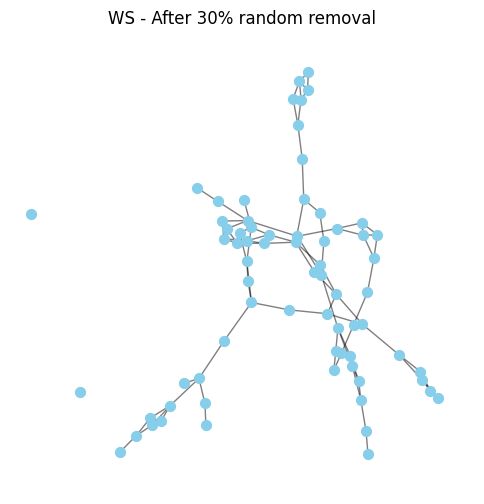

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to plot a network
def plot_graph(G, title):
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Iterate over graphs
for label, G in graphs.items():
    # Plot before removal
    plot_graph(G, f"{label} - Before 30% removal")

    # Apply random removal
    G_after, removed_nodes, giant_frac = random_attack(G, percent=30)

    # Plot after removal
    plot_graph(G_after, f"{label} - After 30% random removal")


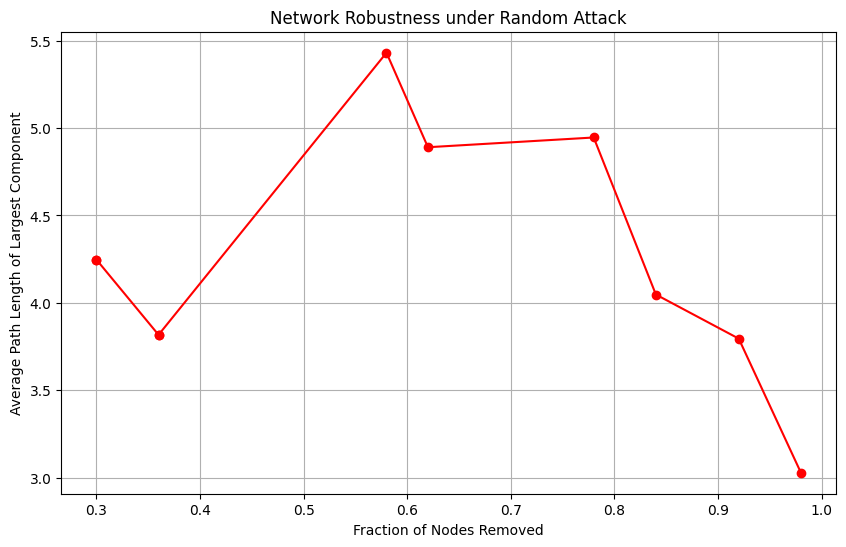

In [ ]:
import networkx as nx
from networkx_robustness import networkx_robustness as netrob
import matplotlib.pyplot as plt

G = nx.barabasi_albert_graph(50, 2)
initial, frac_deg, apl_deg = netrob.simulate_degree_attack(G, attack_fraction=0.2)
initial, frac_betw, apl_betw = netrob.simulate_betweenness_attack(G, attack_fraction=0.2)
initial, frac, apl = netrob.simulate_degree_attack(G, attack_fraction=0.2)

plt.figure(figsize=(10, 6))
plt.plot(frac, apl, marker='o', linestyle='-', color='red')
plt.title('Network Robustness under Random Attack')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Path Length of Largest Component')
plt.grid(True)
plt.show()

In [ ]:
critical_threshold = netrob.critical_threshold(G)
print(critical_threshold)
molloy_reed = netrob.molloy_reed(G)
print(molloy_reed)

None
6.927083333333334


## Heirarchical Model Graph

Generating Hierarchical network (N approx 1000)...


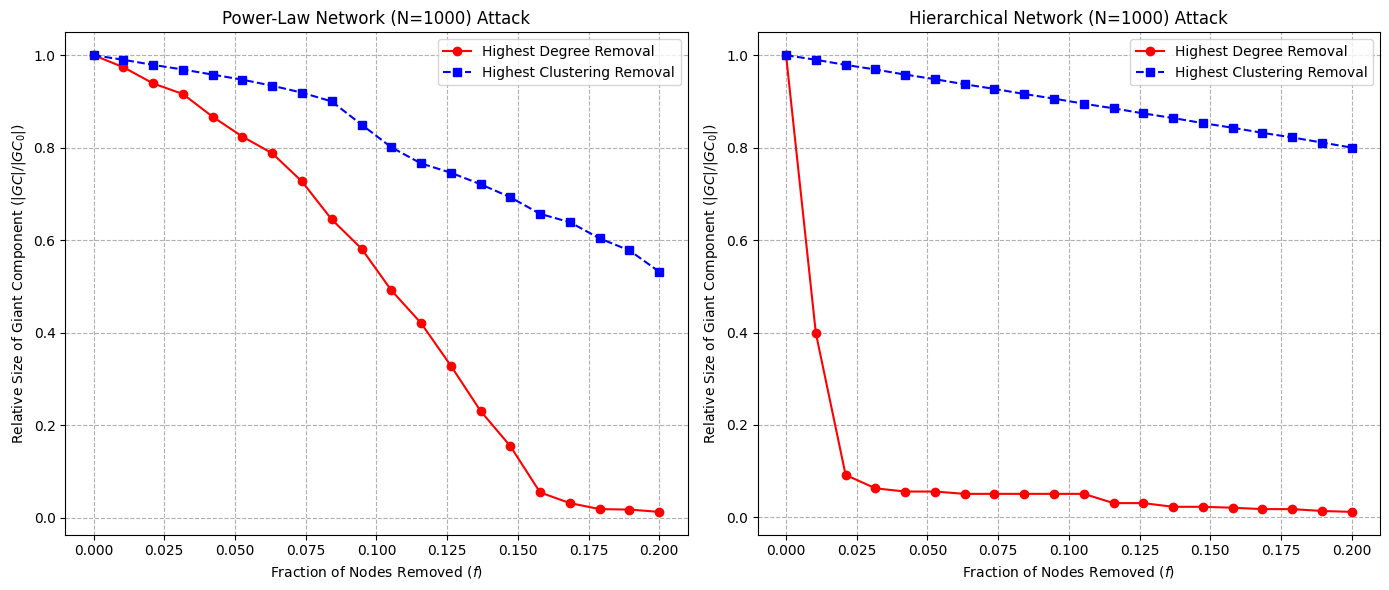

In [ ]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

N_SIM = 1000

def generate_power_law_network(N, gamma=2.5):
    return nx.barabasi_albert_graph(N, m=2)

def generate_hierarchical_network(N, n_base=3, m_rep=3):
    print(f"Generating Hierarchical network (N approx {N})...")

    G = nx.complete_graph(n_base)
    current_size = n_base

    while current_size < N:
        base_node = random.choice(list(G.nodes()))

        new_nodes = list(range(current_size, current_size + n_base))
        new_G = nx.complete_graph(new_nodes)

        G = nx.disjoint_union(G, new_G)

        for node in new_nodes:
            G.add_edge(base_node, node)

        current_size += n_base

    if len(G.nodes()) > N:
        G_nodes = list(G.nodes())
        nodes_to_keep = random.sample(G_nodes, N)
        G = G.subgraph(nodes_to_keep).copy()

    if not nx.is_connected(G):
        G_components = list(nx.connected_components(G))
        G = G.subgraph(max(G_components, key=len)).copy()

    return G

def giant_component_size(G):
    if not G.nodes():
        return 0
    return len(max(nx.connected_components(G), key=len))

def run_attack_simulation(G, attack_type, removal_fractions):
    G_copy = G.copy()
    initial_gc_size = giant_component_size(G_copy)

    if initial_gc_size == 0:
        return np.zeros_like(removal_fractions)

    if attack_type == 'degree':
        ranking = sorted(G_copy.degree(), key=lambda x: x[1], reverse=True)
    elif attack_type == 'clustering':
        clustering_coeffs = nx.clustering(G_copy)
        ranking = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)
    else:
        raise ValueError("Invalid attack type.")

    nodes_to_remove = [node for node, value in ranking]
    num_nodes = len(G.nodes())

    gc_sizes = []

    removed_nodes_set = set()

    for fraction in removal_fractions:
        count_to_remove = int(np.floor(fraction * num_nodes))

        nodes_to_add = set(nodes_to_remove[:count_to_remove]) - removed_nodes_set

        G_copy.remove_nodes_from(nodes_to_add)
        removed_nodes_set.update(nodes_to_add)

        gc_size = giant_component_size(G_copy)
        gc_sizes.append(gc_size / initial_gc_size)

    return gc_sizes

removal_fractions = np.linspace(0, 0.2, 20)

G_pl = generate_power_law_network(N_SIM)
results_pl_deg = run_attack_simulation(G_pl, 'degree', removal_fractions)
results_pl_cc = run_attack_simulation(G_pl, 'clustering', removal_fractions)

G_hier = generate_hierarchical_network(N_SIM)
results_hier_deg = run_attack_simulation(G_hier, 'degree', removal_fractions)
results_hier_cc = run_attack_simulation(G_hier, 'clustering', removal_fractions)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(removal_fractions, results_pl_deg, 'r-o', label='Highest Degree Removal')
plt.plot(removal_fractions, results_pl_cc, 'b--s', label='Highest Clustering Removal')
plt.title(f'Power-Law Network (N={len(G_pl.nodes())}) Attack')
plt.xlabel('Fraction of Nodes Removed ($f$)')
plt.ylabel('Relative Size of Giant Component ($|GC|/|GC_0|$)')
plt.legend()
plt.grid(True, linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(removal_fractions, results_hier_deg, 'r-o', label='Highest Degree Removal')
plt.plot(removal_fractions, results_hier_cc, 'b--s', label='Highest Clustering Removal')
plt.title(f'Hierarchical Network (N={len(G_hier.nodes())}) Attack')
plt.xlabel('Fraction of Nodes Removed ($f$)')
plt.ylabel('Relative Size of Giant Component ($|GC|/|GC_0|$)')
plt.legend()
plt.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx

N = 1000
m = 3
p_triangle = 0.6
G = nx.powerlaw_cluster_graph(N, m, p_triangle)